In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install catboost

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import yaml
import numpy as np
import pandas as pd

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from catboost import Pool, CatBoostClassifier

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *
from match_forecast.formatters import *

2025-04-23 19:03:53.953 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
CONFIG_DIR = PROJ_ROOT / "config"
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_data.shape

(12303, 275)

In [7]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

In [9]:
space = {
    # analogous to n_estimators
    'iterations':            hp.quniform('iterations', 100, 2000, 50),

    # tree depth (max_depth)
    'depth':                 hp.quniform('depth', 3, 10, 1),

    # learning rate (shrinkage)
    'learning_rate':         hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),

    # L2 regularization (reg_lambda)
    'l2_leaf_reg':           hp.uniform('l2_leaf_reg', 1.0, 10.0),

    # “feature_fraction” → random subspace method
    'rsm':                   hp.uniform('rsm', 0.2, 0.8),

    # bagging (used instead of bootstrap + min_samples_split)
    'bagging_temperature':   hp.uniform('bagging_temperature', 0.0, 1.0),

    # how many bins to use for numeric features
    'border_count':          hp.quniform('border_count', 32, 255, 32),

    # random noise in score calculation (like random_state)
    'random_strength':       hp.uniform('random_strength', 0.0, 10.0),

    # tree growth strategy
    'grow_policy':           hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),

    # class weights (None or Balanced)
    'auto_class_weights':    hp.choice('auto_class_weights', [None, 'Balanced']),
}


In [10]:
n_splits = 3

def objective(params):
    for int_param in ('iterations', 'depth', 'border_count'):
        if int_param in params:
            params[int_param] = int(params[int_param])
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, valid_index in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = CatBoostClassifier(
            loss_function='MultiClass',
            eval_metric='MultiClass',
            allow_writing_files=False,
            verbose=False,
            thread_count=-1,
            random_seed=42,
            **params
        )        
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_valid_fold)
        accuracy = accuracy_score(y_valid_fold, y_pred)
        accuracies.append(accuracy)

    mean_loss = 1 - np.mean(accuracies)
    return {'loss': mean_loss, 'status': STATUS_OK}

In [11]:
train = False

if train:
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=150, 
                trials=trials)

    print("Best hyperparameters:", best)

    results = [
        {
            **convert_numpy(trial['result']),
            'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
        }
        for trial in trials.trials
    ]

    raw_params = min(results, key=lambda x: x["loss"])['params']
    formatted_params = format_catboost(raw_params)

    with open(CONFIG_DIR / "catboost_params.yaml", "w") as f:
        yaml.dump(formatted_params, f)

In [12]:
with open(CONFIG_DIR / "catboost_params.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [13]:
cfg

{'auto_class_weights': None,
 'bagging_temperature': 0.7869654255816461,
 'border_count': 128,
 'depth': 3,
 'grow_policy': 'SymmetricTree',
 'iterations': 1750,
 'l2_leaf_reg': 9.29983250494077,
 'learning_rate': 0.015657706431599187,
 'random_strength': 2.571043443663362,
 'rsm': 0.6929088964409026}

In [14]:
catboost_model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    allow_writing_files=False,
    verbose=False,
    thread_count=-1,
    random_seed=42,
    **cfg
)

catboost_model.fit(X_train, y_train)

In [15]:
y_pred_final = catboost_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (test) : {final_accuracy * 100:.2f}%")

Accuracy (test) : 49.82%


In [16]:
importance_dict = dict(zip(
    X_train.columns,
    catboost_model.feature_importances_
))

sorted_features = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)
top_features = [feature for feature, score in sorted_features[:10]]

X_reduced = train_data[top_features]

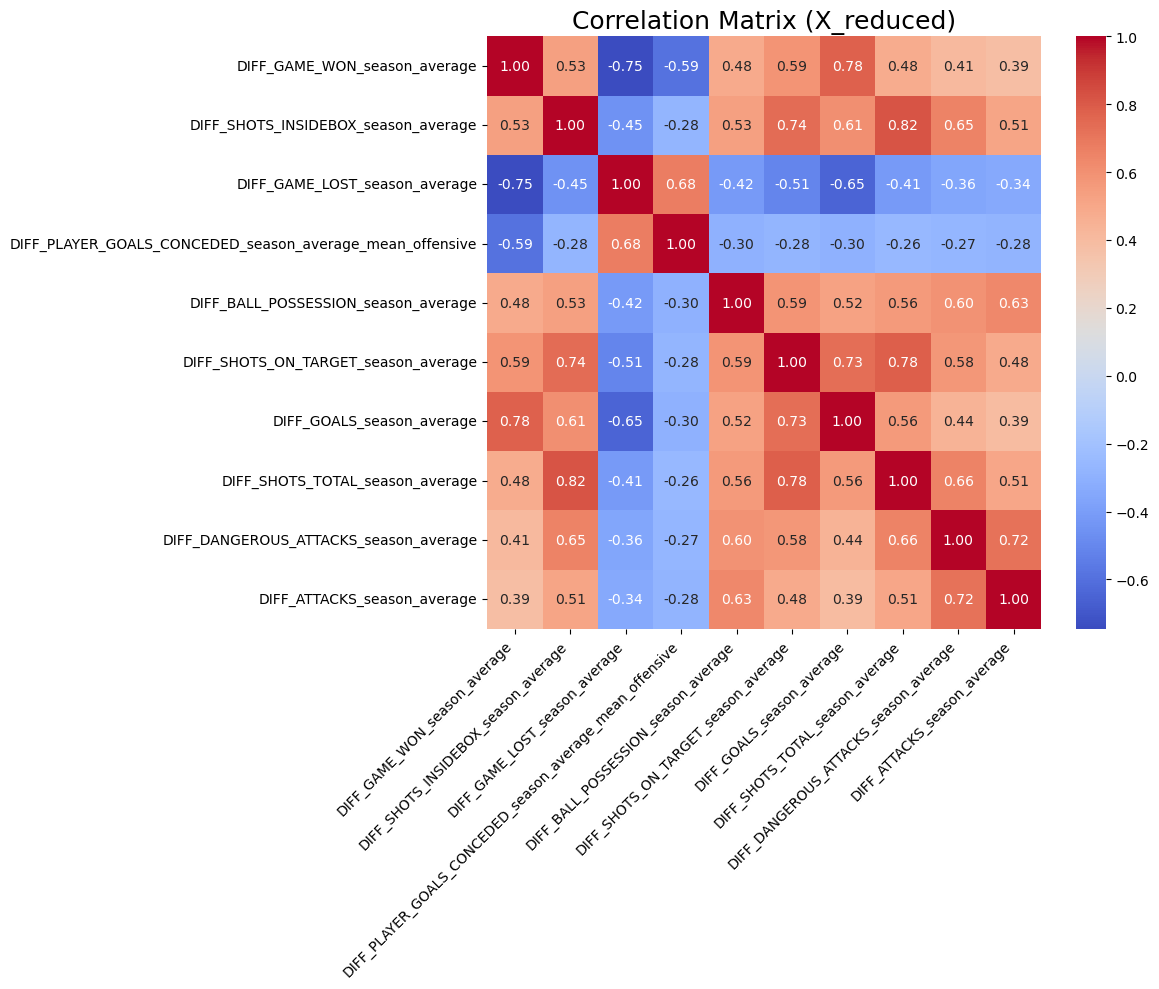

In [17]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

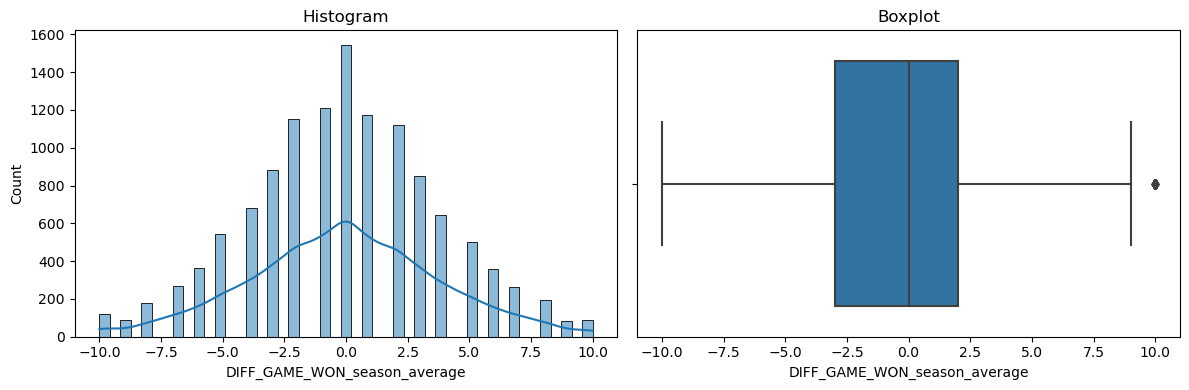

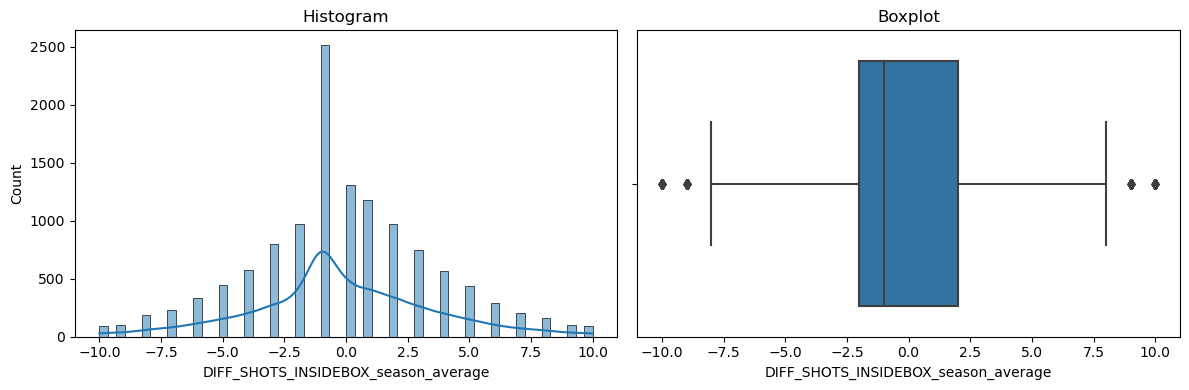

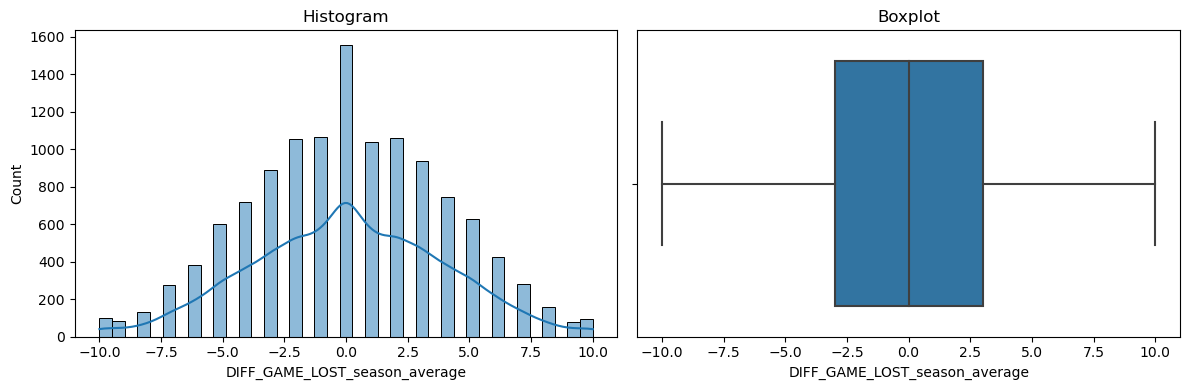

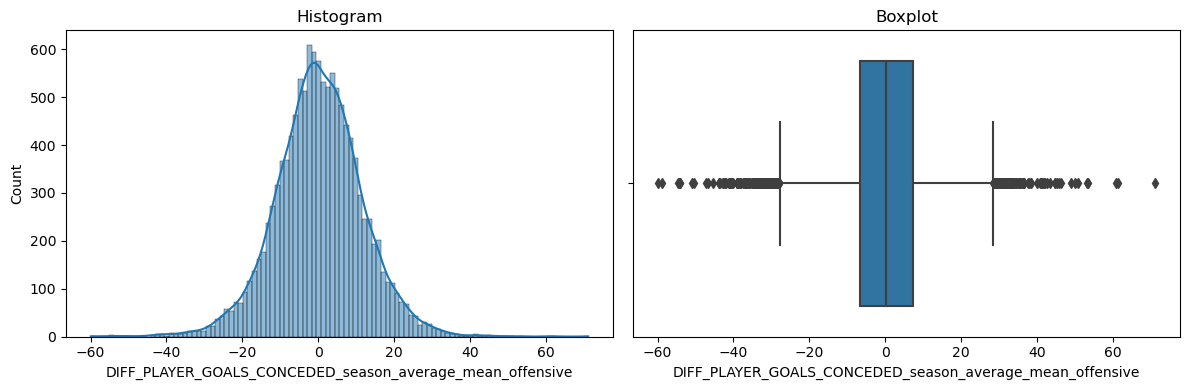

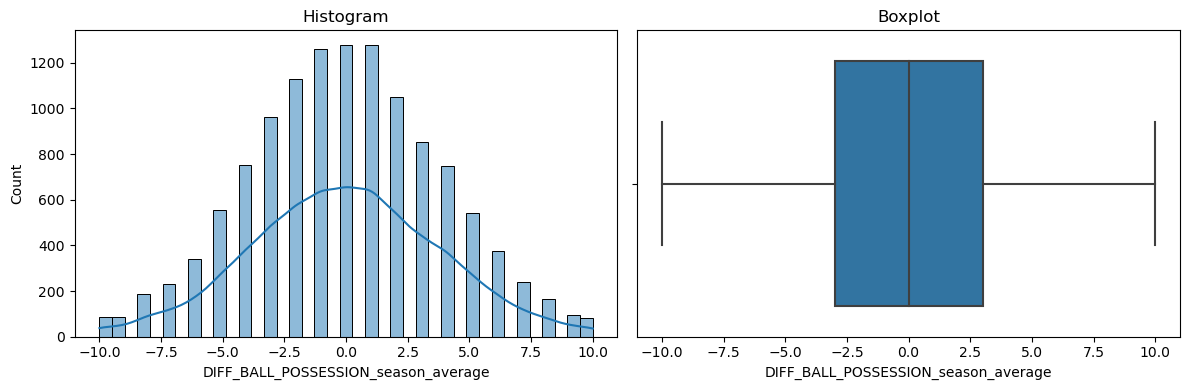

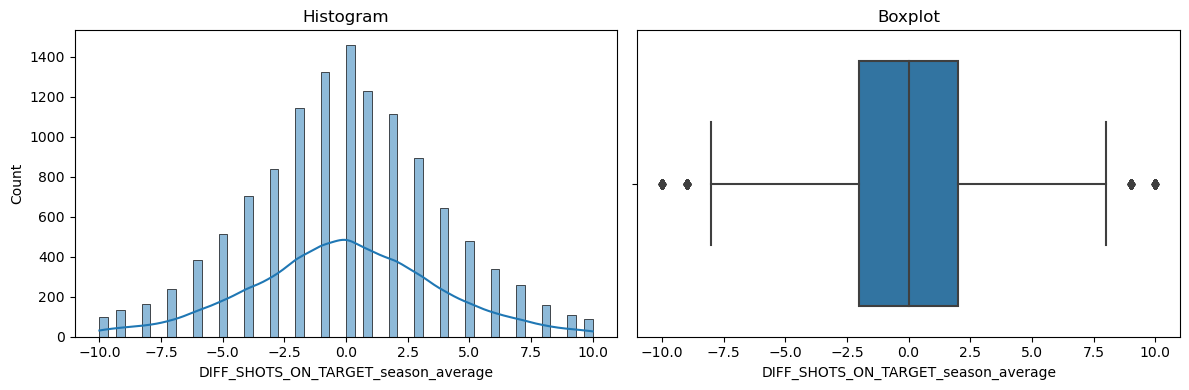

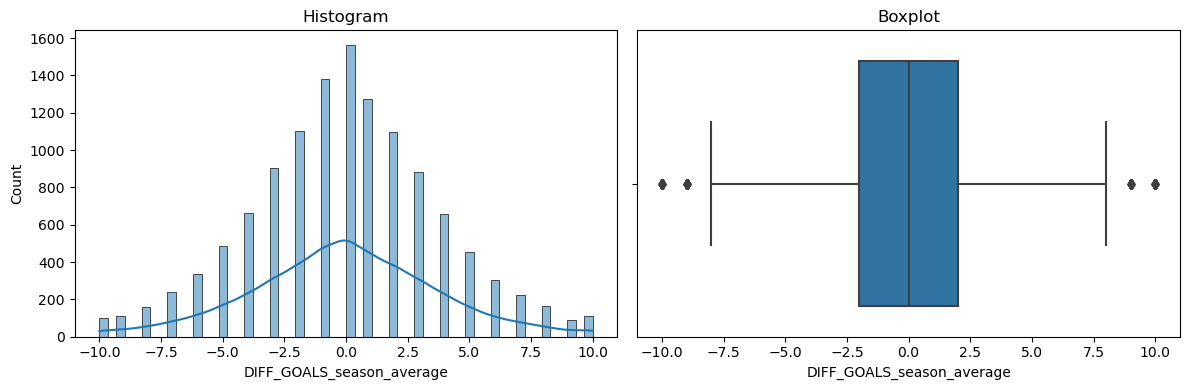

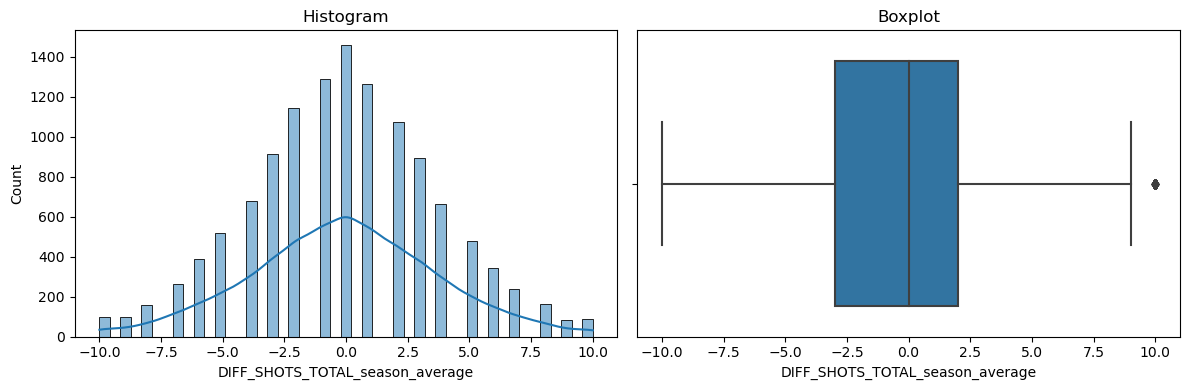

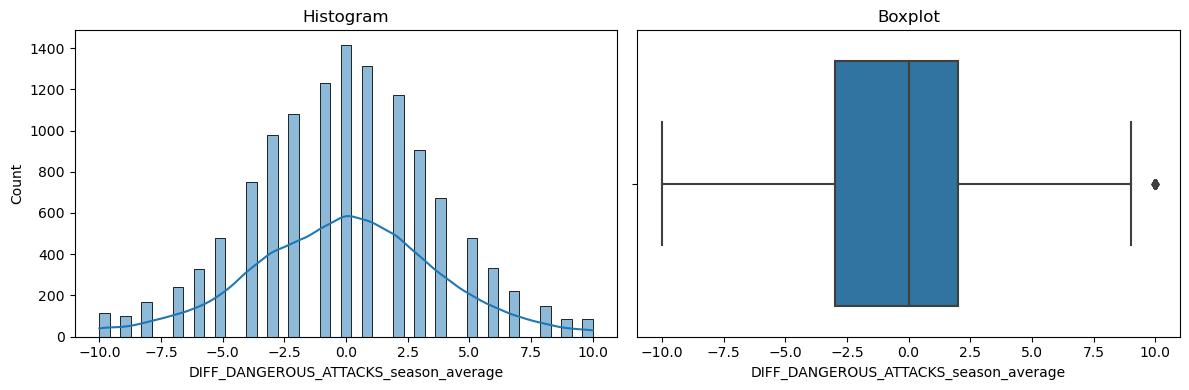

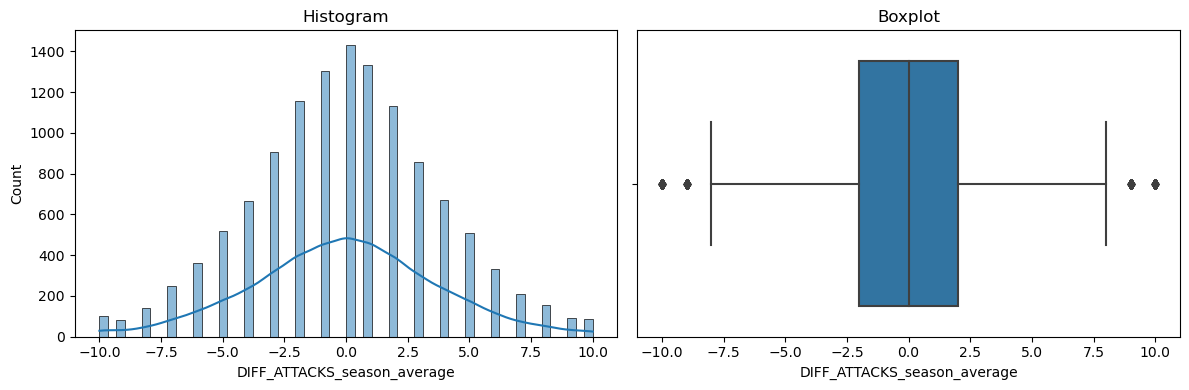

In [18]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)